# step1) 데이터 수집

In [147]:
import os
import urllib.request

import pandas as pd
import numpy as np

# 전처리
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 시각화
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 모델 구성
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [148]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [149]:
data.sample(10)

,headlines,text
4424,"Rats drank 1,000 litres of seized liquor in UP...",The police have claimed that a 'gang of rats' ...
47745,NASA spacecraft witnesses solar eclipse from s...,NASA's Solar Dynamics Observatory saw a total ...
57655,Keep vehicles' headlights on even during day: ...,Jharkhand Chief Minister Raghubar Das on Wedne...
9975,Andhra gets state emblem nearly five years aft...,Nearly five years after the bifurcation of And...
61554,Doctor suspended for Facebook post on dengue d...,A doctor at a West Bengal government hospital ...
50793,SC dismisses plea for SIT probe in attack on K...,The Supreme Court has dismissed a plea to cons...
54413,35-year-old ex-Aus captain takes one-handed fl...,Former Australia captain George Bailey pulled ...
72452,Russia aims to boost voter turnout with flash ...,The Russian Election Commission has ordered a ...
28398,Grass seemed greener when he bowled: Sehwag wi...,Former Indian cricketer Virender Sehwag took t...
37971,"If govt can't, we will avenge his death: Marty...","The brother of Aurangzeb, an Army jawan who wa..."


# step2) 데이터 전처리

- 중복 데이터 제거
- 텍스트 정규화
- 텍스트 정제
- 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거해야할까?

## 2-1. 중복 존재하는 행 제거
- Text행

In [150]:
print(f'전체 샘플 수 : ', data['text'].count())
for col in data.columns:
    print(f'{col}에서 유일한 샘플의 수 : ', data[col].nunique())

전체 샘플 수 :  98401
headlines에서 유일한 샘플의 수 :  98280
text에서 유일한 샘플의 수 :  98360


In [151]:
print('전체 중복 샘플 수 : ',data['text'][data['headlines'].duplicated() & data['text'].duplicated()].count())
data[data['headlines'].duplicated() & data['text'].duplicated()]

전체 중복 샘플 수 :  23


,headlines,text
51012,Longest Test innings was longer than 10 footba...,Former Pakistani cricketer Hanif Mohammad batt...
53731,"Captain once dropped himself, replacement brok...",England captain Mike Denness left himself out ...
55374,India marks National Mathematics Day in memory...,National Mathematics Day is celebrated on Dece...
58769,Indian bowler once took 2 hat-tricks in a sing...,Former Services' medium-pacer Joginder Rao pic...
59705,Why is England-Australia Test series called 'T...,England was beaten at home for the first time ...
60724,Sachin's debut was not telecast in India due t...,The Test in which Sachin Tendulkar made his in...
60885,Who is the cricketer with longest known surnam...,Fijian cricketer Ilikena Lasarusa Talebulamain...
62063,An ODI was once played in the middle of a Test...,Zimbabwe played an ODI against New Zealand in ...
62575,Virat Kohli took a wicket on the 0th ball of h...,Virat Kohli dismissed England's Kevin Pieterse...
63533,Bhabha convinced PM Nehru to start India's nuc...,"Born on October 30, 1909, Padma Bhushan-awarde..."


- 중복된 데이터 중 하나를 확인해보자.

In [152]:
dup = data[data['headlines'].str.contains('Longest Test innings was longer than 10 footba.')]
dup
for col in dup.columns:
    print(f'{col} 길이')
    print(dup[col].map(len))
dup.loc[1017] == dup.loc[51012]

headlines 길이
1017     54
51012    54
Name: headlines, dtype: int64
text 길이
1017     366
51012    366
Name: text, dtype: int64


headlines    True
text         True
dtype: bool

- 우연히 뉴스 제목만 겹친 것이 아니라 뉴스 기사 내용까지 동일한 샘플이 23개나 존재했다. 중복된 행들을 아예 제거하자.

In [153]:
data.drop_duplicates(['headlines','text'], inplace=True)

In [154]:
print(f'전체 샘플 수 : ', data[col].count())
for col in data.columns:
    print(f'{col}에서 유일한 샘플의 수 : ', data[col].nunique())

전체 샘플 수 :  98379
headlines에서 유일한 샘플의 수 :  98280
text에서 유일한 샘플의 수 :  98360


## 2-2. 축약문 정규화
- \`를 사용해 축약된 문장을 다시 풀어주기 위한 정규화 사전을 구축한다.

In [12]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


## 2-3. 불용어 제거
- `NLTK` 불용어 리스트 참고해 샘플에서 불용어 제거하자.
- 총 179개의 불용어가 정의되어 있다.
- 짧은 문장인 `Summary`는 제거하지 않는다.
- `Text`에서만 불용어를 제거하자.

In [13]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

## 2-4. 전처리
- 앞서 생성한 축약어 사전과 불용어 목록을 활용해 전처리를 진행한다.
- 소문자화
- html 태그 포함된 경우 제거
- 괄호 안에 포함된 문자열 제거
- 소유격 's 제거
- 특수문자 및 숫자 제거
- m이 3개 이상이면 무의미한 경우이므로 제거

In [170]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [171]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


- 전체 데이터셋을 cpu 코어수 만큼 분할해서 멀티 프로세싱으로 전처리한다.

In [172]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_sentence(s, remove_stopwords),
    return texts

def preprocess_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

In [173]:
clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

187.81767416000366  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [174]:
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) # 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

6.206622362136841  seconds
['upgrad learner switches to career in ml al with salary hike'
 'delhi techie wins free food from swiggy for one year on cred'
 'new zealand end rohit sharma led india match winning streak' ...
 'the matrix film to get reboot reports'
 'snoop dogg aims gun at clown dressed as trump in new video'
 'madhesi morcha withdraws support to nepalese government']


- 전처리한 결과를 데이터셋에 적용한다.
- 전처리 결과 공백이 된 경우 `np.nan`으로 대체한다.

In [175]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('',np.nan, inplace=True)

In [ ]:
# 재 학습의 경우 토큰까지 추가한 파일 불러오기
#data = pd.read_csv('news_summary_preprocessed.csv')

## 2-5. 문장길이 분포 정리

- text와 headlines의 최대길이, 최소길이, 평균길이 및 분포를 확인하자.
- 전체 문장 분포에 비해서 너무 긴 문장은 제거해서 전체 데이터에 패딩이 적게 들어갈 수 있는 길이를 정한다.

In [159]:
for col in data.columns:
    print(f'{col} 열 최대 길이 :', data[col].map(len).max())

headlines 열 최대 길이 : 86
text 열 최대 길이 : 513


headlines 최소 길이 :  1
headlines 최대 길이 :  18
headlines 평균 길이 :  9.553786885412537


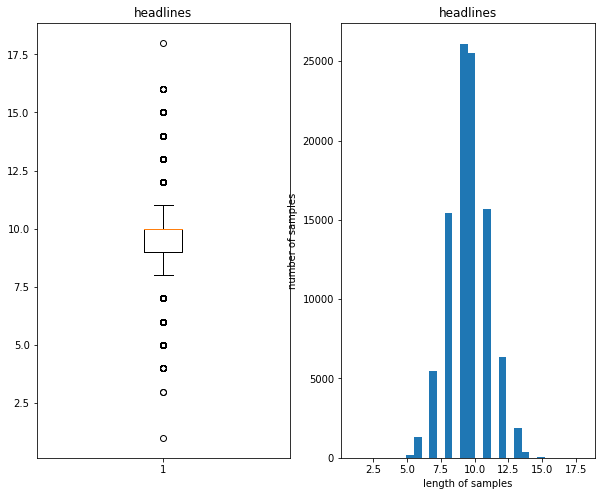

text 최소 길이 :  1
text 최대 길이 :  91
text 평균 길이 :  58.23830288984438


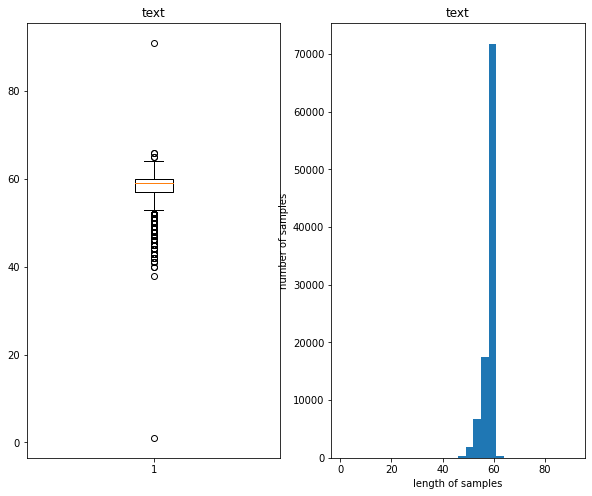

In [158]:
for col in data.columns:
    cols_len = [len(s.split()) for s in data[col]]

    print(f'{col} 최소 길이 : ',np.min(cols_len))
    print(f'{col} 최대 길이 : ',np.max(cols_len))
    print(f'{col} 평균 길이 : ',np.mean(cols_len))
    
    f, ax=plt.subplots(1,2,figsize=(10,8))
    ax[0].boxplot(cols_len)
    ax[0].set_title(col)
    
    ax[1].set_title(col)
    ax[1].hist(cols_len, bins = 30)
    ax[1].set_xlabel('length of samples')
    ax[1].set_ylabel('number of samples')
    
    plt.show()

In [90]:
for col in data.columns:
    cols_len = pd.Series([len(s.split()) for s in data[col]]).value_counts()
    print(cols_len)

9     26107
10    25515
11    15691
8     15435
12     6362
7      5490
13     1864
6      1302
14      338
5       182
15       67
4        12
16       10
3         2
1         1
18        1
dtype: int64
60    42779
59    17955
58    11071
57     7421
56     5795
55     4306
54     3049
53     2122
52     1494
51      980
50      655
49      233
61      204
48      119
47       65
46       43
62       19
64       18
45       17
44        7
43        7
63        5
42        3
41        3
40        2
66        2
65        2
1         1
38        1
91        1
dtype: int64


- 대부분의 text 단어개수 값이 66 이하에 분포하고 있다. 91 단어의 문장은 너무 많은 패딩이 들어가는 것을 막기 위해 제거하자.
- 요약은 18개 단어 내로 비교적 좁은 범위에 분포하고 있다. 굳이 삭제할 필요는 없어보인다.

In [176]:
text_max_len = 67
headlines_max_len = 18

In [161]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [162]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 67 이하인 샘플의 비율: 0.9999898352290632
전체 샘플 중 길이가 18 이하인 샘플의 비율: 1.0


In [177]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98378


## 2-6. 결측치 제거
- 전처리 이후 결측치가 존재하는 지 확인한다.

In [164]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

## 2-7. 시작 토큰, 종료 토큰 추가

- 요약 데이터는 디코더의 입력이 되어 실제 요약을 생성하는데 사용되므로 시작 토큰과 종료 토큰을 추가한다.

In [178]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [179]:
data.to_csv('news_summary_preprocessed.csv',index=None)

In [167]:
# 재 학습 수행 시 전처리 진행한 파일 불러오기
data = pd.read_csv('news_summary_preprocessed.csv')

In [181]:
data.sample(5)

,headlines,text,decoder_input,decoder_target
9649,juventus apologises for suicide condolence to ...,portugal captain cristiano ronaldo club juvent...,sostoken juventus apologises for suicide condo...,juventus apologises for suicide condolence to ...
48923,beyonc would not be as successful with darker ...,beyonc father mathew knowles said daughter wou...,sostoken beyonc would not be as successful wit...,beyonc would not be as successful with darker ...
22866,chitrangda role in saheb biwi aur cut short re...,chitrangda singh role saheb biwi aur gangster ...,sostoken chitrangda role in saheb biwi aur cut...,chitrangda role in saheb biwi aur cut short re...
11009,yr old girl dies in landslide in people rescued,nine year old bakarwal girl died three family ...,sostoken yr old girl dies in landslide in peop...,yr old girl dies in landslide in people rescue...
92038,kashmiri scholar leaves bits pilani after faci...,hashim sofi kashmiri scholar birla institute t...,sostoken kashmiri scholar leaves bits pilani a...,kashmiri scholar leaves bits pilani after faci...


## 2-8. train, test 데이터 분리

- 기사 원문은 인코더의 입력으로
- 시작 토큰을 붙인 기사 제목은 디코더의 입력으로
- 종료 토큰을 붙인 기사 제목은 디코더의 레이블로 만든다.

In [180]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [182]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[72215 25401 87758 ... 82643 69134 85081]


In [183]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [184]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19675


In [185]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78703
훈련 레이블의 개수 : 78703
테스트 데이터의 개수 : 19675
테스트 레이블의 개수 : 19675


## 2-9. 출현 빈도 적은 단어 제외
- 데이터셋의 전체 단어 사전 크기는 매우 큰데에 비해 실제 사용 빈도수가 높은 단어는 몇 개 되지 않는다.
- 특정 빈도수 이상으로 나타나는 경우만 포함하자.

In [186]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

- 적절한 빈도수 임계치를 찾아보자.

In [28]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어 사전 단어 개수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69579
등장 빈도가 8번 이하인 희귀 단어의 수: 50165
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19414
단어 집합에서 희귀 단어의 비율: 72.09790310294773
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.231518533164515


- 빈도수 9 이상의 단어들로 전체 데이터셋의 95.8% 정도를 커버할 수 있으므로 빈도수가 9일 때의 단어 사전 크기인 20000을 인코더의 단어 사전 크기로 정한다.

In [187]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

## 2-10. 정수 인코딩 - `Tokenizer.texts_to_sequneces(txt_data)`
- 실제 모델에서 사용할 수 있도록 문자열 시퀀스를 정수 시퀀스로 변환한다.

In [188]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[472, 1266, 58, 1, 1853, 741, 410, 1001, 328, 6561, 5610, 1379, 6740, 663, 170, 29, 5016, 6740, 1509, 15334, 201, 63, 1266, 1, 104, 5610, 835, 207, 70, 54, 3133], [2073, 328, 1253, 4101, 335, 6740, 29, 1509, 12, 206, 755, 1617, 328, 1717, 949, 4101, 259, 1172, 18, 949, 1700, 335, 1423, 18, 98, 949, 2, 1328, 276, 835, 207, 70, 1253, 4101, 3307, 70], [1559, 9, 2776, 5155, 19, 7, 3679, 1835, 9, 334, 475, 975, 3354, 7085, 869, 3502, 2674, 1191, 2164, 4176, 1835, 2391, 333, 132, 3574, 10, 230, 825, 7486, 904, 833, 797, 9, 301]]


In [189]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30038
등장 빈도가 8번 이하인 희귀 단어의 수: 21868
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8170
단어 집합에서 희귀 단어의 비율: 72.80111858312803
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.526439387305295


In [190]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 6473, 3500, 23, 10, 1936, 668, 1039, 16, 695, 559], [1, 1368, 4402, 1039, 181, 354, 89, 6, 1904, 705], [1, 1535, 30, 44, 1018, 60, 460], [1, 7684, 1074, 248, 3, 110, 37, 1243], [1, 1163, 2539, 4403, 1574, 41, 333, 3, 2493]]
target
decoder  [[6473, 3500, 23, 10, 1936, 668, 1039, 16, 695, 559, 2], [1368, 4402, 1039, 181, 354, 89, 6, 1904, 705, 2], [1535, 30, 44, 1018, 60, 460, 2], [7684, 1074, 248, 3, 110, 37, 1243, 2], [1163, 2539, 4403, 1574, 41, 333, 3, 2493, 2]]


## 2-11. 전처리 결과 결측치 제거

In [191]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 78703
훈련 레이블의 개수 : 78703
테스트 데이터의 개수 : 19674
테스트 레이블의 개수 : 19674


## 2-10. 패딩

In [192]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# step3) 어텐션 매커니즘 사용

## 3-1. 인코더 설계

In [193]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

## 3-2. 디코더 설계

In [194]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [195]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

## 3-3. 어텐션 매커니즘 적용

In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [196]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 67, 128)      2560000     input_6[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 67, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

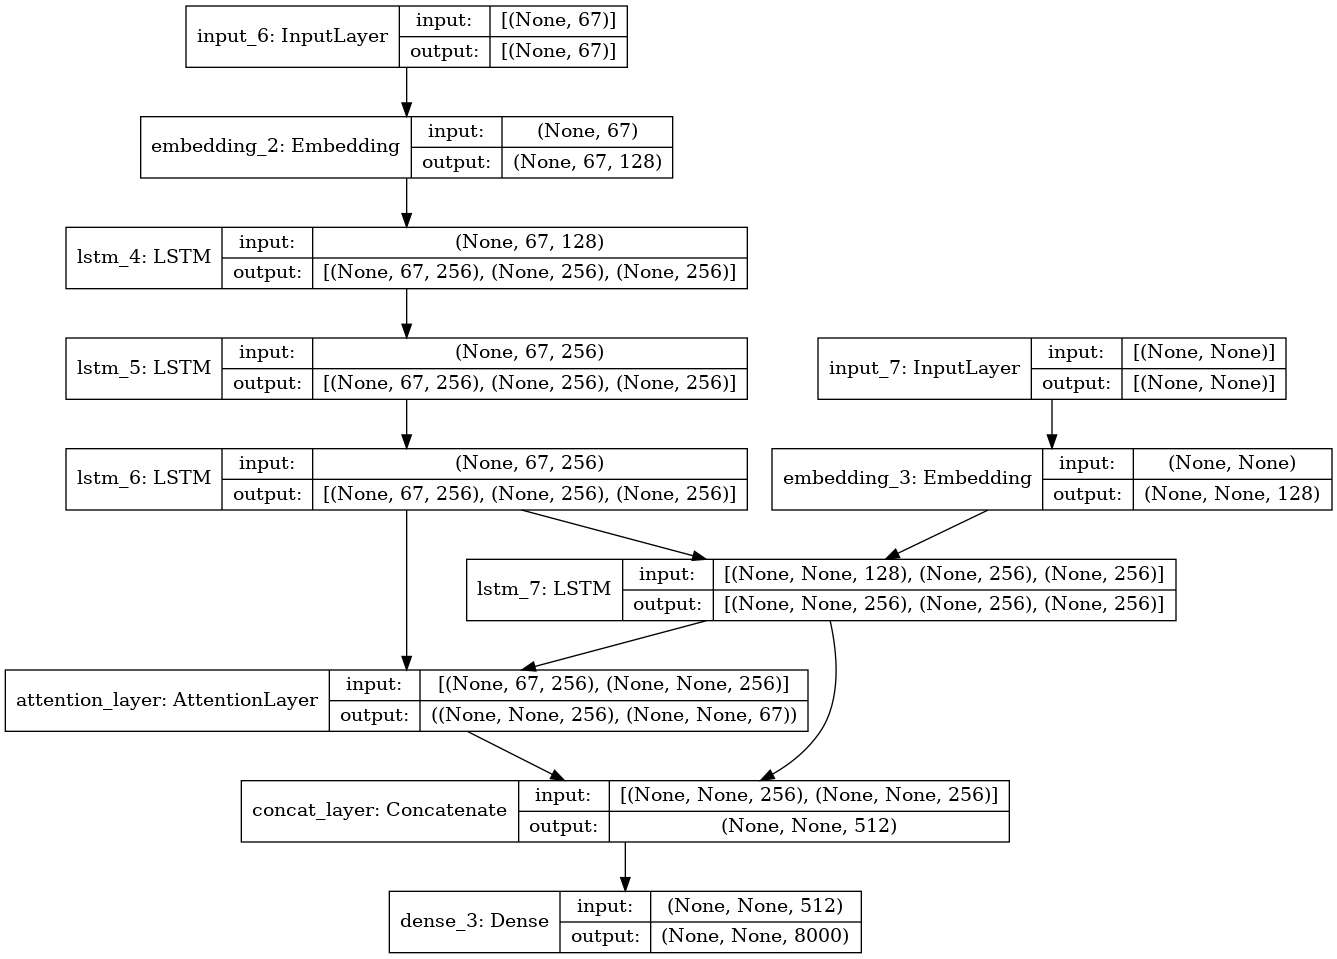

In [197]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

## 3-4. 모델 훈련

In [164]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 312s 983ms/step - loss: 4.0964 - val_loss: 3.3904
Epoch 2/50
307/307 [==============================] - 303s 986ms/step - loss: 3.3536 - val_loss: 3.1362
Epoch 3/50
307/307 [==============================] - 302s 985ms/step - loss: 3.0861 - val_loss: 2.9361
Epoch 4/50
307/307 [==============================] - 301s 980ms/step - loss: 2.8896 - val_loss: 2.8003
Epoch 5/50
307/307 [==============================] - 296s 966ms/step - loss: 2.7402 - val_loss: 2.7069
Epoch 6/50
307/307 [==============================] - 296s 966ms/step - loss: 2.6193 - val_loss: 2.6293
Epoch 7/50
307/307 [==============================] - 296s 965ms/step - loss: 2.5197 - val_loss: 2.5696
Epoch 8/50
307/307 [==============================] - 296s 965ms/step - loss: 2.4229 - val_loss: 2.5110
Epoch 9/50
307/307 [==============================] - 296s 965ms/step - loss: 2.3519 - val_loss: 2.4693
Epoch 10/50
307/307 [==============================] - 297s 968m

## 3-5. 모델 저장

In [ ]:
path=os.getenv('HOME')+'/aiffel/enode10/news_summarization/news_model/model1'
model.save(path)

In [44]:
weights_path=os.getenv('HOME')+'/aiffel/enode10/news_summarization/news_checkpoints/model1_checkpoint'
new_model.save_weights(weights_path)

In [38]:
import tensorflow as tf
new_model = tf.keras.models.load_model(path)

In [166]:
import joblib
joblib.dump(model.history.history, os.getenv('HOME')+'/aiffel/enode10/news_summarization/news_history/model1_history.pkl')

['/aiffel/aiffel/enode10/news_summarization/news_history/model1_history.pkl']

## cf) 모델 불러오기

In [54]:
model.load_weights(weights_path)

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
import joblib
history = joblib.load(os.getenv('HOME')+'/aiffel/enode10/news_summarization/news_history/model1_history.pkl')

## 3-6. 훈련 결과 시각화

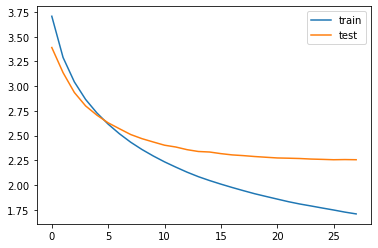

In [41]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

# step4) 실제 결과와 요약문 비교

## 4-1. 정수 인덱스를 텍스트 데이터로 복원

In [198]:
# 정수 인덱스를 텍스트 데이터로 복원하는데 필요한 단어사전 3개
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

## 4-2. 인퍼런스 모델 설계

In [199]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [200]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

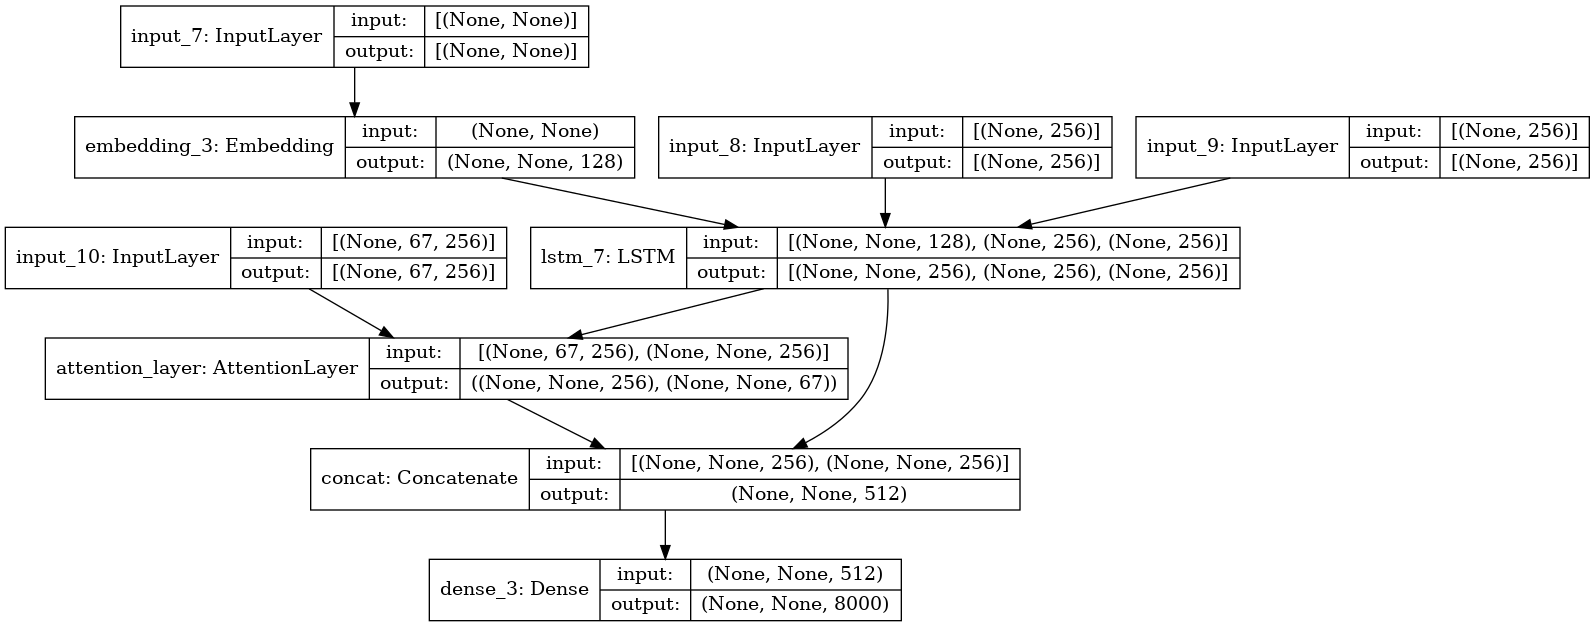

In [201]:
plot_model(decoder_model, to_file='with_attention_model_shapes.png', show_shapes=True)

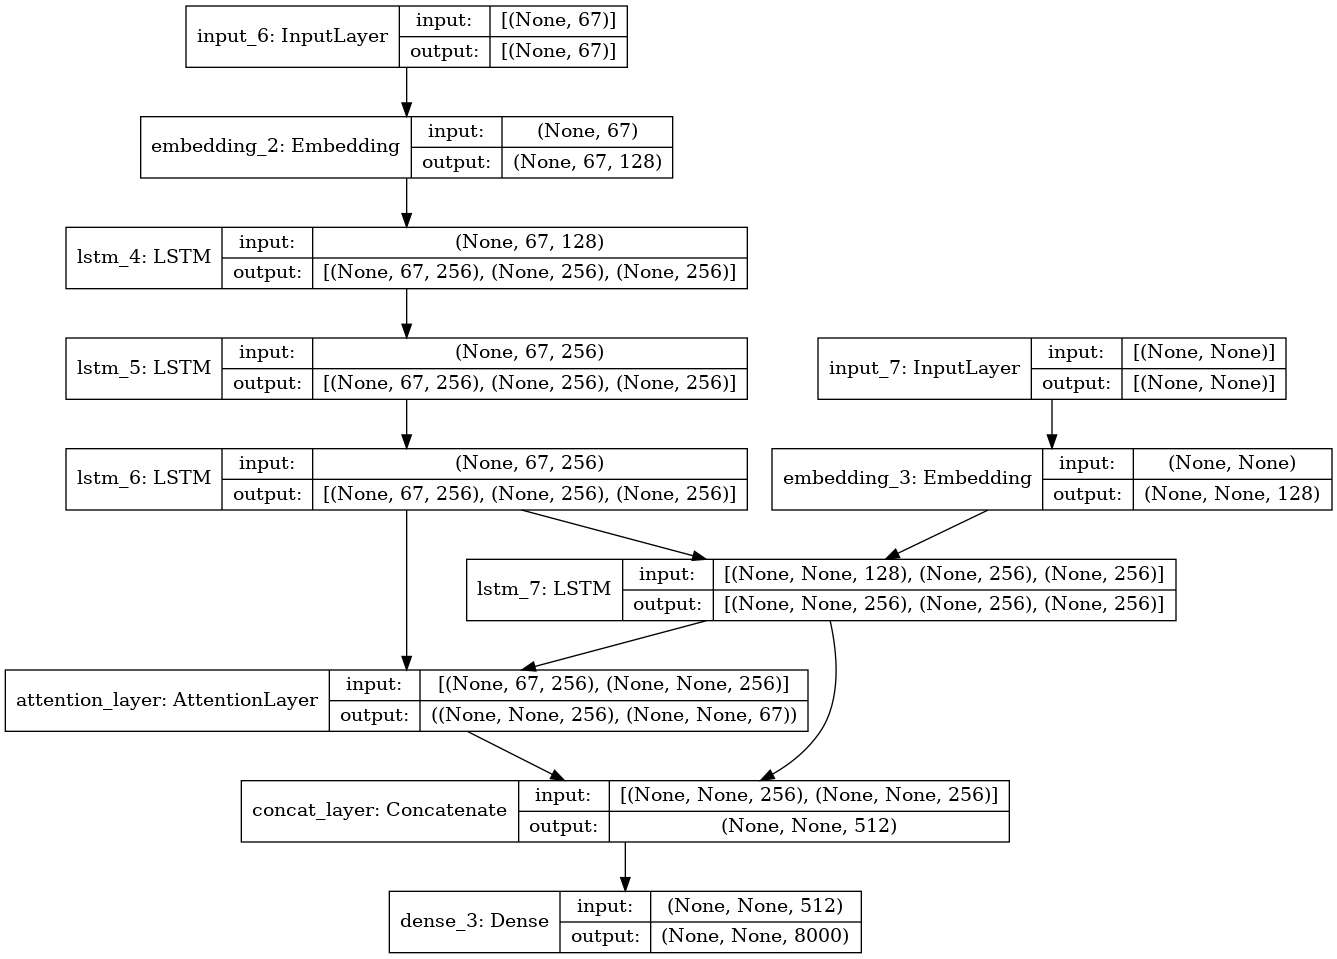

In [202]:
plot_model(model, show_shapes=True)

## 4-3. 인퍼런스 단어 시퀀스 생성

In [292]:
# 원본 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']
    
    token_bag = set()

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [293]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [299]:
indexs = np.random.randint(len(encoder_input_test),size=5)
for i in indexs:
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : subodh kumar singh sho posted killed clashes bulandshahr first investigating officer lynching case case relates mob killing mohammad suspicion cow slaughter beef consumption singh transferred middle investigation chargesheet filed another officer 
실제 요약 : killed in bulandshahr clashes probed lynching 
예측 요약 :  raids divorce posting scindia hospitalised einstein saree ban depressed russia juventus fair faked authority said brahm achieves


원문 : qatar airways ceo akbar al baker monday said airline buy stake jet airways part owned etihad whose owner abu dhabi enemy qatar abu dhabi part uae cut ties qatar accusations supporting terrorism al baker added qatar airways would delighted invest indigo 
실제 요약 : jet airways backed by enemy state will not invest qatar airways ceo 
예측 요약 :  raids intel temple explain sehwag explain unicorn unicorn unicorn keys erdo headed fodder keys deep diplomats achievements


원문 : anti corruption anna hazare friday said delhi cm one time arvind kejriwal sha

- 실제 요약 결과가 그렇게 좋지 못한 편이다. 아예 핵심 키워드가 들어있지 않은 경우도 존재한다.

# step5) `Summa`이용해 추출적 요약

In [300]:
from summa.summarizer import summarize

## 5-1. 데이터 원문으로 추출적 요약

In [111]:
original = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 확실히 `ratio`가 높을 수록 추출에 성공한 문장 개수가 많았다.

In [204]:
ratio = 0.0
while ratio <= 1.0:
    ext_count = 0
    for text in original['text'].sample(50):
        summary = summarize(text, ratio=ratio)
        if summary: # 안비어있으면
            ext_count +=1
    print(f'ratio {ratio} 일때 30개 문장 중 성공한 문장은 {ext_count}개')
    ratio += 0.1

ratio 0.0 일때 30개 문장 중 성공한 문장은 0개
ratio 0.1 일때 30개 문장 중 성공한 문장은 0개
ratio 0.2 일때 30개 문장 중 성공한 문장은 0개
ratio 0.30000000000000004 일때 30개 문장 중 성공한 문장은 1개
ratio 0.4 일때 30개 문장 중 성공한 문장은 39개
ratio 0.5 일때 30개 문장 중 성공한 문장은 50개
ratio 0.6 일때 30개 문장 중 성공한 문장은 50개
ratio 0.7 일때 30개 문장 중 성공한 문장은 49개
ratio 0.7999999999999999 일때 30개 문장 중 성공한 문장은 48개
ratio 0.8999999999999999 일때 30개 문장 중 성공한 문장은 49개
ratio 0.9999999999999999 일때 30개 문장 중 성공한 문장은 50개


- `words` 역시 값이 클 때 추출적 요약이 성공할 확률이 높았다.

In [120]:
words = 1
while words <= text_max_len:
    ext_count = 0
    for text in original['text'].sample(50):
        summary = summarize(text, words=words)
        if summary: # 안비어있으면
            ext_count +=1
    print(f'words {words} 일때 50개 문장 중 성공한 문장은 {ext_count}개')
    words +=5

words 1 일때 50개 문장 중 성공한 문장은 0개
words 6 일때 50개 문장 중 성공한 문장은 1개
words 11 일때 50개 문장 중 성공한 문장은 18개
words 16 일때 50개 문장 중 성공한 문장은 44개
words 21 일때 50개 문장 중 성공한 문장은 48개
words 26 일때 50개 문장 중 성공한 문장은 46개
words 31 일때 50개 문장 중 성공한 문장은 50개
words 36 일때 50개 문장 중 성공한 문장은 49개
words 41 일때 50개 문장 중 성공한 문장은 48개
words 46 일때 50개 문장 중 성공한 문장은 49개
words 51 일때 50개 문장 중 성공한 문장은 47개
words 56 일때 50개 문장 중 성공한 문장은 48개


- 그러나 단어 개수 및 비율이 커질 수록 요약의 의미가 떨어지기 때문에 비율 0.4 정도로 요약을 진행하자.
- 실제 요약과 추출적 요약을 비교하면 문장 길이가 더 길기는 하지만 의미는 비슷한 문장이 만들어 진다.

In [271]:
for text in original['text'].sample(5):
    summary = summarize(text, ratio=0.4)
    if summary: # 안비어있으면
        print(f'원문\n{text}')
        real_summary = original[original['text']==text]['headlines'].iloc[0]
        print(f'실제 요약\n{real_summary}')
        print(f'추출적 요약문\n{summary}')
        print('\n')

원문
US-based software developer Shantini Vyas has developed an app called Pawsy which lets users find and connect their pet dogs with nearby dogs. The app connects pets based on a number of questions related to their personality, size, and style. Pawsy allows users to view other dog profiles on the platform and includes 'add friends' feature. 
실제 요약
App lets users connect their pet dogs with nearby dogs
추출적 요약문
US-based software developer Shantini Vyas has developed an app called Pawsy which lets users find and connect their pet dogs with nearby dogs.


원문
AIMIM chief Asaduddin Owaisi on Wednesday questioned why PM Narendra Modi doesn't sit on fast for "farmers who lost their lives" and for "atrocities on Dalits". Owaisi was reacting to PM Modi's decision to sit on a day-long fast against Parliament disruptions. Ã¢ÂÂWhy doesnÃ¢ÂÂt the prime minister sit on a fast to atone for his false promises?" Owaisi added.
실제 요약
Why doesn't PM Modi fast for farmers, Dalits, asks Owaisi
추출적 요약문
O

## 5-2. 전처리를 거친 후 추상적 요약과 추출적 요약 성능 비교

- 추출적 요약은 구둣점이 중요한 역할을 하기 때문에 구둣점을 제거하지 않는 전처리를 진행한다.

In [254]:
# 추출적 요약용 전처리 함수
def preprocess_extract_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z.,!]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
    texts = []
    for s in sentences:
        texts += preprocess_extract_sentence(s, remove_stopwords),
    return texts

def preprocess_extract_data(data, remove_stopwords=True):
    start_time = time.time()
    num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

    text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
    pool = Pool(num_cores)

    processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
    pool.close()
    pool.join()
    print(time.time() - start_time, " seconds")
    return processed_data

In [237]:
original_pre = original.copy()

In [238]:
original_pre['headlines'] = preprocess_extract_data(original['headlines'], remove_stopwords=False)
original_pre['text'] = preprocess_extract_data(original['text'])
original_pre.replace('',np.nan, inplace=True)

6.031383037567139  seconds
187.28473830223083  seconds


In [300]:
idx = np.random.randint(len(encoder_input_test)-5,size=1)[0]
idx
for i in range(idx, idx+5):
    origin = seq2text(encoder_input_test[i])
    print("원문 :", origin)
    real_summary =  seq2summary(decoder_input_test[i])
    print("실제 요약 :",real_summary)
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    text = original_pre[original_pre['headlines'].str.contains(real_summary[:5])]['text'].iloc[0]
    summary =  summarize(text, ratio=0.99)
    if summary:
        print(f'추출적 요약 : {summary}')    
    else:
        print('추출적 요약 실패')
    print('\n')

원문 : pradeep candidate pyramid party india upcoming telangana assembly elections believes non causing global warming pradeep btech graduate said scientific done proves non one primary reasons global warming huge acres land animal farms breed animals meat 
실제 요약 : non cause of global warming gana party leader 
예측 요약 :  raids intel origin tech warships iraq evms soorma bihar dating cycling dating prabhas lata promoting keeping keeping
추출적 요약 : telangana rashtra samithi secured majority member telangana assembly, caretaker cm chandrashekar rao son kt rama rao said, non congress non bjp force emerging telangana.
added, keen federal front.
earlier, caretaker cm rao said actively participate national politics.


원문 : saudi prince bin talal middle east richest person moved five star hotel held jail refusing pay billion reported settlement saudi authorities billionaire arrested last year around princes officials corruption probe launched government 
실제 요약 : middle east richest man jailed after

### 문법 완성도 측면
- 추상적 요약의 결과가 너무 안좋았다. 동어 반복도 심했고 문법에도 잘 맞지 않아 그냥 단어를 내뱉는 느낌이 강하다.
- 추출적 요약은 추상적 요약에 비해 문법은 준수하나 비교적 짧은 원문을 바탕으로 요약을 하려다보니 `ratio` 값을 키우게 되었고, 그로 인해 요약임에도 꽤 긴 문장을 제공하게 되었다.
- 원본 문장에서 가져오는 비율이 커진 만큼 문법에 맞을 확률도 더 높아진 것 같다.

### 요약 완성도 측면
- 추상적 요약의 경우 아예 다른 이야기를 하는 경우도 보인다.
- 추상적 요약은 동어 반복이 심해서 요약 내용의 질 역시 떨어졌다.
- 이전에 괜찮은 결과를 낸 적이 있었지만 랜덤 속에서 어딘가로 사라졌다.
- 추출적 요약은 비교적 핵심 키워드를 담아내기는 했지만 핵심 문장을 뽑아내지는 못했다.


# 회고
- 아직 모델을 완벽하게 이해하지 못했다보니 어떤 식으로 하이퍼 파라미터를 조절해야 요약의 질이 올라갈지 모르겠다. 그런데 학습에 시간이 오래 걸려서 다양한 시도는 해보지 못했다.
- 추출적 요약에서 꽤 애를 먹었다.
- `ratio` 조절을 시도했어도 안돼서 `gensim`을 다운그레이드 해서 시도해보았는데도 묵묵 부답이었었다.
- 문장 길이기 문제인가 싶어 단어수가 80개 이상인 문장만 요약해보고 정말 갖은 시도를 다했었다..
- 패키지를 제거하거나 관련 의존성 패키지들을 재설치하는 것이 주피터에 바로 반영이 안되는 것 같다. 새로 `gensim`을 설치한 것도 `Import Error`로 한참 힘들었지만 새로 노트북파일을 생성하니까 잘 작동했다. 역시 정신 건강을 위해서는 가상환경을 새로 파고 깔끔하게 시작하는게 좋겠다.
- 추출적 요약에 구둣점을 제외한 다른 부분을 전처리할 경우 성능이 향상되는지 실험해봐야겠다.